# Clicks analysis by user precise


In [27]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import zscore
from scipy.stats import shapiro
from scipy.stats import probplot
from tabulate import tabulate


conn = sqlite3.connect(
    r"C:\Users\max-j\OneDrive\Desktop\Bachelorarbeit_Auswertung\Datenbanken\Auswertung\app_database_2")

queryDataCombinedAvg = """SELECT
                            ClicksDisaggregatedFinal.*,
                            Duration,
                            DurationReached,
                            DurationPrecision,
                            DistanceReached,
                            (((0.1-TestCaseData.DistanceFinished)/ClicksPrecise) * 10000) AS Performance
                          FROM ClicksDisaggregatedFinal
                          RIGHT JOIN TestCaseData
                          ON ClicksDisaggregatedFinal.TestCaseID=TestCaseData.TestCaseID
                            GROUP BY ClicksDisaggregatedFinal.ScenarioCase, ClicksDisaggregatedFinal.TestCaseID;"""

observed_group = 'UserID'
tested_variable = 'Performance'

DataCombinedAvg = pd.read_sql_query(queryDataCombinedAvg, conn)
DataCombinedAvgAggregated = DataCombinedAvg.groupby([observed_group, 'ScenarioCase'])[['Performance', 'ClicksPrecise']].mean().reset_index()

DataCombinedAvgAggregated[f'{tested_variable}_z_within'] = DataCombinedAvgAggregated.groupby('ScenarioCase')[tested_variable].transform(zscore)

for data in DataCombinedAvgAggregated[f'{tested_variable}_z_within']:
    if data >= 2.5 or data <= -2.5:
        print(f"Significant outlier {data}")

# Analyzing Performance

    ScenarioCase  count      mean       std       min       25%       50%  \
0         FOLDAR   12.0  7.477985  2.911371  2.398351  5.727922  7.839785   
1     FOLDAROPEN   12.0  5.532120  2.756021  1.628817  3.628176  5.551363   
2  STATEOFTHEART   12.0  7.116179  3.857585  1.413043  4.866154  5.796045   

         75%        max  ClicksPrecise  
0   9.328552  11.353518     176.941667  
1   6.735949  10.334722     302.437500  
2  10.424235  13.585963     167.508333  


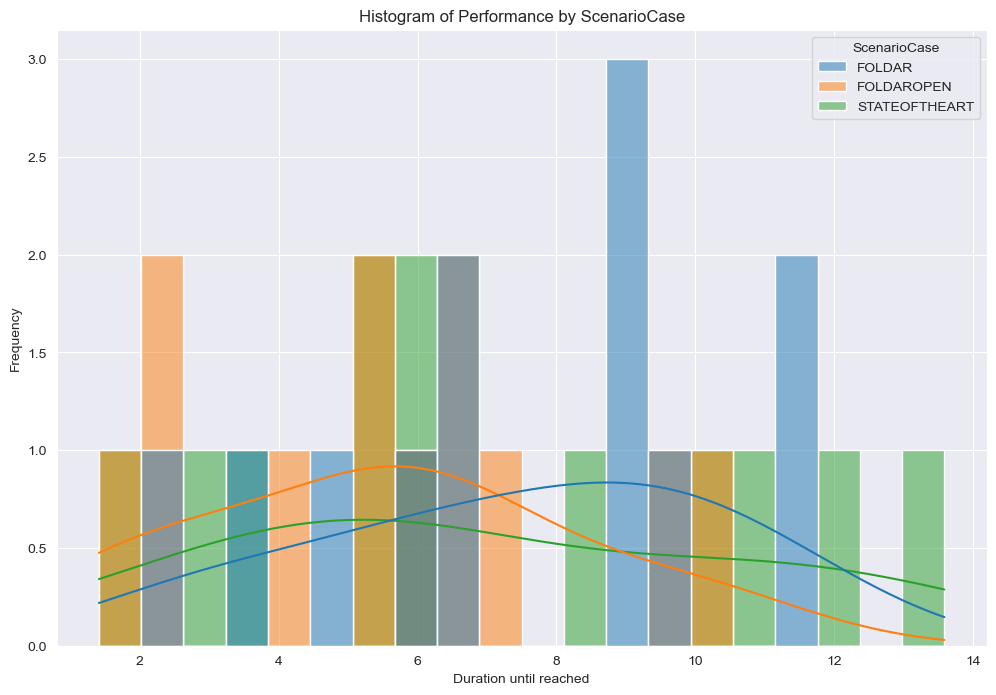

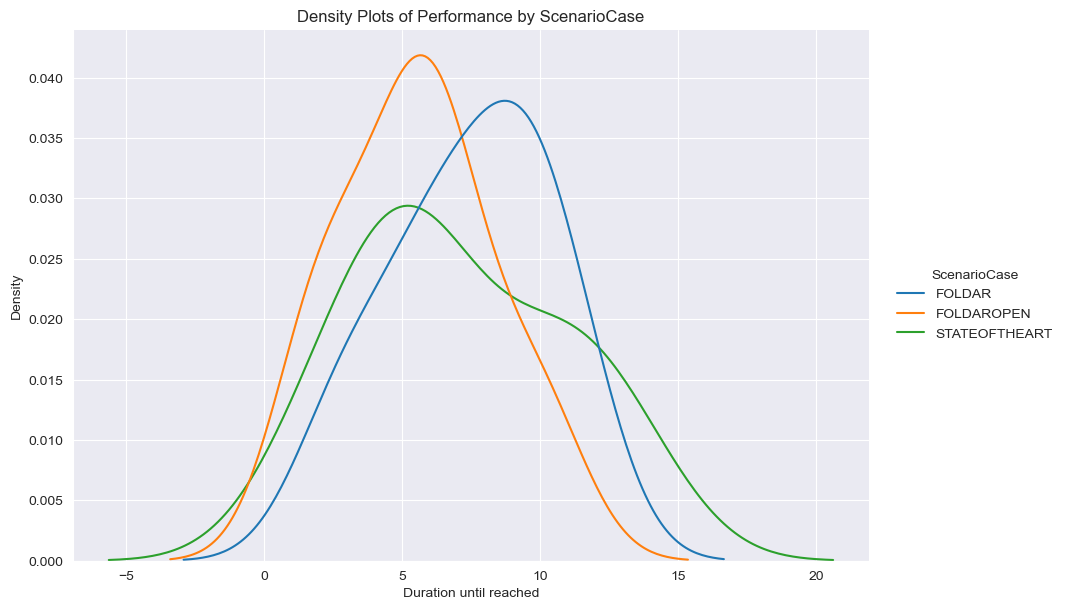

In [28]:
#Average duration for each scenario
summary_stats = DataCombinedAvgAggregated.groupby('ScenarioCase')[tested_variable].describe()
DataUserScenario = DataCombinedAvgAggregated.groupby('ScenarioCase')[["ClicksPrecise"]].mean().reset_index()
# Falls summary_stats den Index "ScenarioCase" hat,
# setze bei DataUserScenario "ScenarioCase" als Schlüssel.
combined_output = pd.merge(
    summary_stats.reset_index(),  # falls summary_stats als Index ScenarioCase hat
    DataUserScenario,
    on='ScenarioCase',
    how='outer'
)
print(combined_output)

plt.figure(figsize=(12, 8))
sns.histplot(data=DataCombinedAvgAggregated, x=tested_variable, hue="ScenarioCase", kde=True, bins=20, alpha=0.5)
plt.title('Histogram of Performance by ScenarioCase')
plt.xlabel("Duration until reached")
plt.ylabel("Frequency")
plt.show()

sns.displot(data=DataCombinedAvgAggregated, x=tested_variable, hue='ScenarioCase', kind="kde", height=6, aspect=1.5)
plt.title("Density Plots of Performance by ScenarioCase")
plt.xlabel("Duration until reached")
plt.ylabel("Density")
plt.show()

# Check for normality

Shapiro-Wilk Normality Test Results per ScenarioCase:
Scenario: FOLDAR          | Shapiro-Wilk Statistic: 0.947511 | p-value: 0.600926
Scenario: FOLDAROPEN      | Shapiro-Wilk Statistic: 0.951839 | p-value: 0.664013
Scenario: STATEOFTHEART   | Shapiro-Wilk Statistic: 0.948202 | p-value: 0.610866


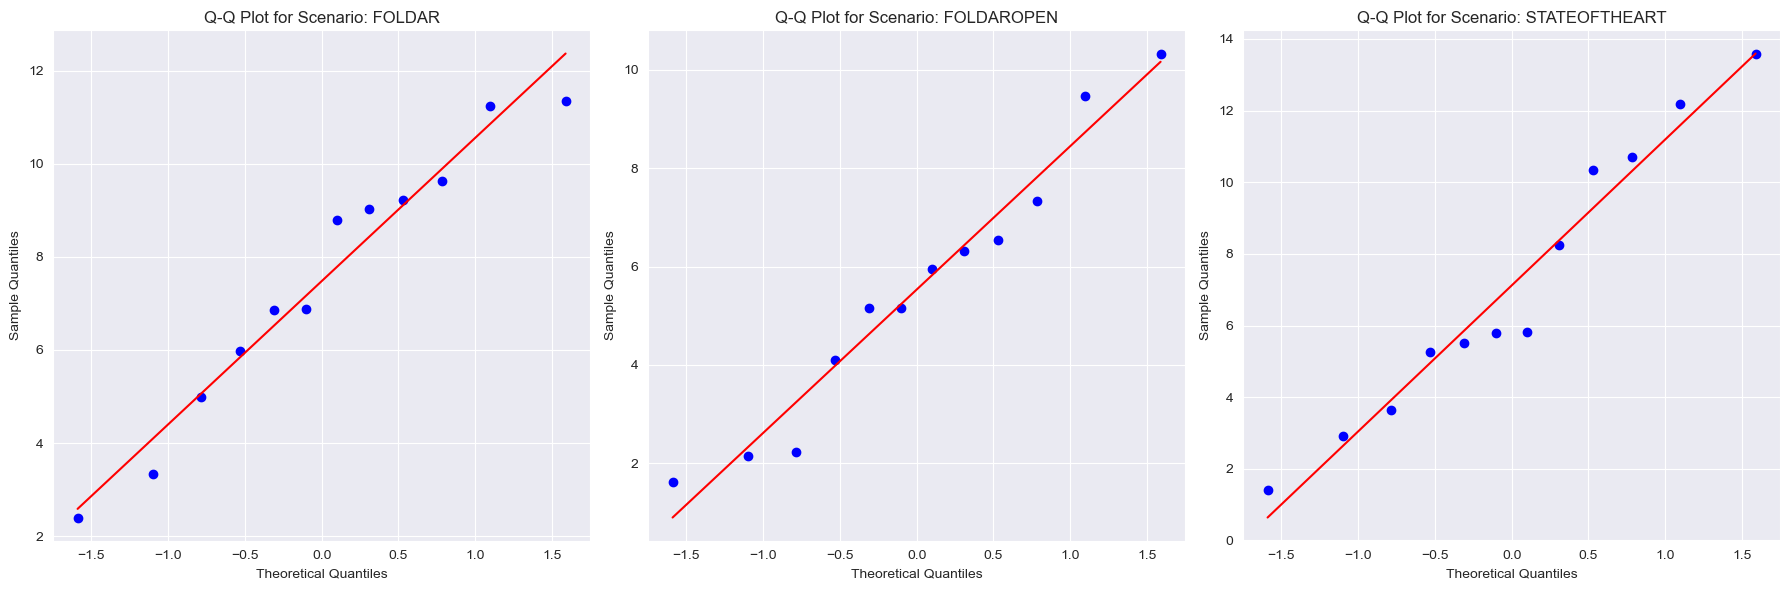

In [29]:
print("Shapiro-Wilk Normality Test Results per ScenarioCase:")
for scenario in DataCombinedAvgAggregated['ScenarioCase'].unique():
    data_scenario = DataCombinedAvgAggregated.loc[
        DataCombinedAvgAggregated['ScenarioCase'] == scenario, tested_variable]
    stat, p_value = shapiro(data_scenario)
    print(f"Scenario: {scenario:<15} | Shapiro-Wilk Statistic: {stat:.6f} | p-value: {p_value:.6f}")

# Get unique scenarios
scenarios = DataCombinedAvgAggregated['ScenarioCase'].unique()
n_scenarios = len(scenarios)

# Create a subplot grid. For example, one row with n_scenarios columns:
fig, axs = plt.subplots(1, n_scenarios, figsize=(6 * n_scenarios, 6))

# In case there's only one scenario, wrap the ax in a list
if n_scenarios == 1:
    axs = [axs]

# Loop over each scenario and respective subplot axis
for ax, scenario in zip(axs, scenarios):
    data_to_plot = DataCombinedAvgAggregated.loc[
        DataCombinedAvgAggregated['ScenarioCase'] == scenario, tested_variable]
    probplot(data_to_plot, dist="norm", plot=ax)
    ax.set_title(f"Q-Q Plot for Scenario: {scenario}")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")

plt.tight_layout()
plt.show()

# Mauchlys Test

In [30]:
sphericity_results = pg.sphericity(DataCombinedAvgAggregated, dv=tested_variable, within='ScenarioCase',
                                   subject=observed_group, method='mauchly', alpha=0.05)

header = f"{'Spher':<10} {'W':<15} {'Chi2':<15} {'Dof':<10} {'P-Value':<15}"
print("\nMauchly's Test for Sphericity Results:")
print(header)
print("-" * len(header))

row = f"{str(sphericity_results.spher):<10} " \
      f"{sphericity_results.W:<15.6f} " \
      f"{sphericity_results.chi2:<15.6f} " \
      f"{sphericity_results.dof:<10} " \
      f"{sphericity_results.pval:<15.6f}"
print(row)


Mauchly's Test for Sphericity Results:
Spher      W               Chi2            Dof        P-Value        
---------------------------------------------------------------------
True       0.695752        3.627625        2          0.163031       


# Repeated Anova


Repeated Measures ANOVA Results:

+--------------+----------+------+----------+----------+------------+-------------+------------+
| Source       |       SS |   DF |       MS |        F |      p-unc |         ng2 |        eps |
|--------------+----------+------+----------+----------+------------+-------------+------------|
| ScenarioCase |  25.7062 |    2 | 12.8531  |   2.0949 |   0.146959 |   0.0701998 |   0.766725 |
| Error        | 134.979  |   22 |  6.13543 | nan      | nan        | nan         | nan        |
+--------------+----------+------+----------+----------+------------+-------------+------------+


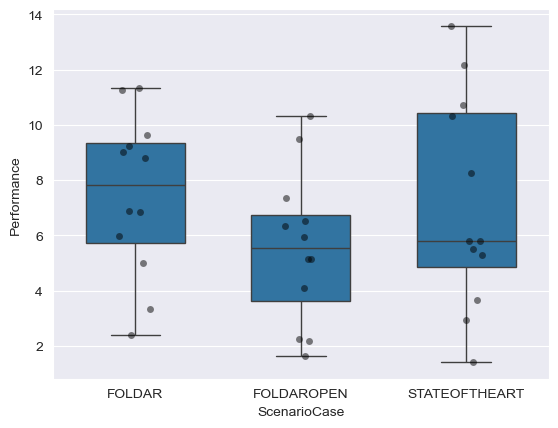

In [31]:
rm_anova = pg.rm_anova(data=DataCombinedAvgAggregated,
                       dv=tested_variable,
                       subject=observed_group,
                       within=['ScenarioCase'],
                       detailed=True)

# Print results
print("\nRepeated Measures ANOVA Results:\n")
print(tabulate(rm_anova, headers='keys', tablefmt='psql', showindex=False))

sns.boxplot(data=DataCombinedAvgAggregated, x='ScenarioCase', y=tested_variable, width=0.6, showfliers=False)
sns.stripplot(data=DataCombinedAvgAggregated, x='ScenarioCase', y=tested_variable, color='black', alpha=0.5)
plt.show()